In [6]:
import numpy as np
import torch

from nnunetv2.training.loss.deep_supervision import DeepSupervisionWrapper
from nnunetv2.training.loss.dice import MemoryEfficientSoftDiceLoss
from nnunetv2.training.nnUNetTrainer.nnUNetTrainer import nnUNetTrainer
from nnunetv2.utilities.helpers import softmax_helper_dim1


class nnUNetTrainerCompoundLoss(nnUNetTrainer):
    def _build_loss(self):
        loss = MemoryEfficientSoftDiceLoss(**{'batch_dice': self.configuration_manager.batch_dice,
                                    'do_bg': self.label_manager.has_regions, 'smooth': 1e-5, 'ddp': self.is_ddp},
                            apply_nonlin=torch.sigmoid if self.label_manager.has_regions else softmax_helper_dim1)

        if self.enable_deep_supervision:
            deep_supervision_scales = self._get_deep_supervision_scales()

            # we give each output a weight which decreases exponentially (division by 2) as the resolution decreases
            # this gives higher resolution outputs more weight in the loss
            weights = np.array([1 / (2 ** i) for i in range(len(deep_supervision_scales))])
            weights[-1] = 0

            # we don't use the lowest 2 outputs. Normalize weights so that they sum to 1
            weights = weights / weights.sum()
            # now wrap the loss
            loss = DeepSupervisionWrapper(loss, weights)
        return loss

nnUNet_raw is not defined and nnU-Net can only be used on data for which preprocessed files are already present on your system. nnU-Net cannot be used for experiment planning and preprocessing like this. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up properly.
nnUNet_preprocessed is not defined and nnU-Net can not be used for preprocessing or training. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up.
nnUNet_results is not defined and nnU-Net cannot be used for training or inference. If this is not intended behavior, please read documentation/setting_up_paths.md for information on how to set this up.


In [4]:
import nrrd
idd = "Diseased_4"
#idd = "Normal_12.nrrd"
imgname = f"~/Desktop/nnUNet_raw/Dataset666_ASOCA/imagesTr/{idd}_0000.nrrd"
labname = f"~/Desktop/nnUNet_raw/Dataset666_ASOCA/labelsTr/{idd}.nrrd"
img, img_header = nrrd.read(imgname)
lab, lab_header = nrrd.read(labname)

FileNotFoundError: [Errno 2] No such file or directory: '~/Desktop/nnUNet_raw/Dataset666_ASOCA/imagesTr/Diseased_4_0000.nrrd'

In [4]:
for i in range(1,21):
    try:
        idd = f"Diseased_{i}.nrrd"
        idd = f"Normal_{i}.nrrd"
        imgname = f"nnUNet_raw/Dataset666_ASOCA/imagesTr/{idd}"
        #labname = f"nnUNet_raw/Dataset666_ASOCA/labelsTr/{idd}"
        img, img_header = nrrd.read(imgname)
        #lab, lab_header = nrrd.read(labname)
    except:
        print("Error in ", i)

Error in  1
Error in  2
Error in  3
Error in  4
Error in  5
Error in  6
Error in  7
Error in  8
Error in  9
Error in  10
Error in  11
Error in  12
Error in  13
Error in  14
Error in  15
Error in  16
Error in  17
Error in  18
Error in  19
Error in  20


In [7]:
lab.shape

(512, 512, 224)

In [8]:
lab_header

OrderedDict([('type', 'short'),
             ('dimension', 3),
             ('space', 'left-posterior-superior'),
             ('sizes', array([512, 512, 224])),
             ('space directions',
              array([[0.41992199, 0.        , 0.        ],
                     [0.        , 0.41992199, 0.        ],
                     [0.        , 0.        , 0.625     ]])),
             ('kinds', ['domain', 'domain', 'domain']),
             ('endian', 'little'),
             ('encoding', 'gzip'),
             ('space origin',
              array([ -80.90000153, -129.6000061 , -220.625     ]))])

In [1]:
import matplotlib.pyplot as plt
plt.imshow(lab[:,:,120])

ModuleNotFoundError: No module named 'matplotlib'

In [19]:
#TODO: make a file of test/train data. Kör 5fold valid, since we have so little?
import numpy as np
test_diseased = np.random.randint(1, 21, size=5)
test_normal = np.random.randint(1, 21, size=5)
with open("test.txt", 'w') as f:
    for i in test_diseased:
        f.write(f"Diseased_{i}.nrrd\n")
    for i in test_normal:
        f.write(f"Normal_{i}.nrrd\n")
print("diseased:", test_diseased)
print("normal:", test_normal)

diseased: [ 9  1  5 18 19]
normal: [ 4 10  3  1  9]


In [13]:
#TODO: check for UNet if Ts is for validation or actual test? Also, are you able to run it? 
#.     can you really add new losses easily? Is it worth it?


In [5]:
L=nrrd.read("/home/maia-user/Desktop/nnUNet_raw/Dataset666_ASOCA/labelsTr/Diseased_10.nrrd")

In [6]:
L[0].shape


(512, 512, 224)

In [26]:
L[1]

OrderedDict([('type', 'int16'),
             ('dimension', 3),
             ('space', 'left-posterior-superior'),
             ('sizes', array([512, 512, 224])),
             ('space directions',
              array([[0.38671899, 0.        , 0.        ],
                     [0.        , 0.38671899, 0.        ],
                     [0.        , 0.        , 0.625     ]])),
             ('kinds', ['domain', 'domain', 'domain']),
             ('endian', 'little'),
             ('encoding', 'gzip'),
             ('space origin',
              array([ -75.69999695, -111.80000305, -224.375     ]))])

In [27]:
(L[0].min(),L[0].max())

(0, 1)

In [29]:
len(list(Path('nnUNet_raw', 'Dataset666_ASOCA','labelsTr').glob('*.nrrd')))

30

In [31]:
from typing import Callable
import torch
from nnunetv2.training.loss.dice import SoftDiceLoss, MemoryEfficientSoftDiceLoss
from nnunetv2.utilities.helpers import softmax_helper_dim1
from torch import nn
import torch.nn.functional as F


class soft_cldice(nn.Module):
    def __init__(self, apply_nonlin: Callable = None, iter_: int = 3, smooth: float = 1.):
        super(soft_cldice, self).__init__()
        self.iter = iter_
        self.smooth = smooth
        self.apply_nonlin = apply_nonlin

    def forward(net_output, gt):
        with torch.no_grad():
            if net_output.ndim != gt.ndim:
                gt = gt.view((gt.shape[0], 1, *gt.shape[1:]))

            if net_output.shape == gt.shape:
                # if this is the case then gt is probably already a one hot encoding
                y_onehot = gt
            else:
                y_onehot = torch.zeros(net_output.shape, device=net_output.device)
                y_onehot.scatter_(1, gt.long(), 1)
        if self.apply_nonlin is not None:
            x = self.apply_nonlin(x)

        skel_pred = soft_skel(net_output, self.iter)
        skel_true = soft_skel(y_onehot, self.iter)
        tprec = (torch.sum(torch.multiply(skel_pred, y_onehot)[:,1:,...])+self.smooth)/(torch.sum(skel_pred[:,1:,...])+self.smooth)    
        tsens = (torch.sum(torch.multiply(skel_true, net_output)[:,1:,...])+self.smooth)/(torch.sum(skel_true[:,1:,...])+self.smooth)    
        cl_dice = 1.- 2.0*(tprec*tsens)/(tprec+tsens)
        return cl_dice
    


def soft_erode(img):
    if len(img.shape)==4:
        p1 = -F.max_pool2d(-img, (3,1), (1,1), (1,0))
        p2 = -F.max_pool2d(-img, (1,3), (1,1), (0,1))
        return torch.min(p1,p2)
    elif len(img.shape)==5:
        p1 = -F.max_pool3d(-img,(3,1,1),(1,1,1),(1,0,0))
        p2 = -F.max_pool3d(-img,(1,3,1),(1,1,1),(0,1,0))
        p3 = -F.max_pool3d(-img,(1,1,3),(1,1,1),(0,0,1))
        return torch.min(torch.min(p1, p2), p3)


def soft_dilate(img):
    if len(img.shape)==4:
        return F.max_pool2d(img, (3,3), (1,1), (1,1))
    elif len(img.shape)==5:
        return F.max_pool3d(img,(3,3,3),(1,1,1),(1,1,1))


def soft_open(img):
    return soft_dilate(soft_erode(img))


def soft_skel(img, iter_):
    img1  =  soft_open(img)
    skel  =  F.relu(img-img1)
    for j in range(iter_):
        img  =  soft_erode(img)
        img1  =  soft_open(img)
        delta  =  F.relu(img-img1)
        skel  =  skel +  F.relu(delta-skel*delta)
    return skel




In [ ]:
cl_kwargs = 
self.cl = soft_cldice(apply_nonlin=softmax_helper_dim1, **cl_kwargs)

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import nrrd
from pathlib import Path

In [12]:
pot = Path("nnUNet_results", "Dataset666_ASOCA")
potCl = Path(pot, "nnUNetTrainerClDSC_250epochs_lossequal__nnUNetPlans__3d_fullres", "fold_0")
potFR0 = Path(pot, "nnUNetTrainer_150epochs__nnUNetPlans__3d_fullres", "fold_0")

potClold = Path(pot, "nnUNetTrainerClDSC_150epochs__nnUNetPlans__3d_fullres", "fold_2")
potFR2 = Path(pot, "nnUNetTrainer_150epochs__nnUNetPlans__3d_fullres", "fold_2")

gt_imgs = Path("nnUNet_raw", "Dataset666_ASOCA", "imagesTr")
gt_label = Path("nnUNet_raw", "Dataset666_ASOCA", "labelsTr")

fold0 = ["Diseased_13", "Diseased_2","Diseased_6","Normal_11","Normal_14","Normal_5"]
fold2 = ["Diseased_3","Diseased_4","Diseased_7","Normal_15","Normal_18","Normal_19"]


In [13]:
## check new clDSC (equal weight of Cl and DSC, 250 epochs) against gt and original nnunet 150epochs
# get all results
rndnr = np.random.randint(0,high=6)
imgname = fold0[rndnr]+'.nrrd'
imgCl, headerCl = nrrd.read(Path(potCl, 'validation', imgname))
imgFR0, headerFR0 = nrrd.read(Path(potFR0, 'validation', imgname))
imgGT, headerIGT = nrrd.read(Path(gt_imgs, imgname[:-5]+'_0000.nrrd'))
#make CT volume grayscale
imgGT[imgGT<-300]=-300
imgGT[imgGT>500] = 500
imgGT = (imgGT-imgGT.min())
imgGT = imgGT/imgGT.max() * 255
labGT, headerLGT = nrrd.read(Path(gt_label,imgname))
fantom = np.stack((imgGT, imgGT, imgGT), -1).astype(np.int32)


FileNotFoundError: [Errno 2] No such file or directory: 'nnUNet_results/Dataset666_ASOCA/nnUNetTrainerClDSC_250epochs_lossequal__nnUNetPlans__3d_fullres/fold_0/validation/Normal_14.nrrd'

In [55]:
vol_Cl = fantom.copy()
vol_Cl[...,0][imgCl>0] = 255
vol_Cl[...,1][imgCl>0] = 0
vol_Cl[...,2][imgCl>0] = 0

vol_FR0 = fantom.copy()
vol_FR0[...,0][imgFR0>0] = 255
vol_FR0[...,1][imgFR0>0] = 0
vol_FR0[...,2][imgFR0>0] = 0

vol_GT0 = fantom.copy()
vol_GT0[...,0][labGT>0] = 255
vol_GT0[...,1][labGT>0] = 0
vol_GT0[...,2][labGT>0] = 0

(0.0, 500.0, 0.0, 500.0)

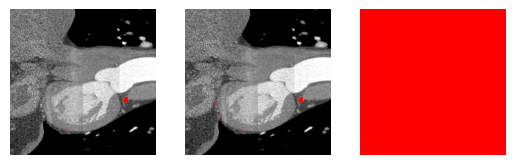

In [56]:
#plot
sls=":,250,:"
a=500
plt.figure()
plt.subplot(1,3,1)
plt.imshow(eval("vol_GT0["+sls+",:]"), extent=(0, a, 0, a))
plt.axis("off")
plt.subplot(1,3,2)
plt.imshow(eval("vol_FR0["+sls+",:]"), extent=(0, a, 0, a))
plt.axis("off")
plt.subplot(1,3,3)
plt.imshow(eval("vol_Cl["+sls+",:]"), extent=(0, a, 0, a))
plt.axis("off")



In [10]:
## check old clDSC ( weight of Cl and DSC 0.3 vs 0.7, 150 epochs) against gt and original nnunet 150epochs
# get all results
rndnr = np.random.randint(0,high=6)
imgname = fold2[rndnr]+'.nrrd'
imgCl, headerCl = nrrd.read(Path(potClold, 'validation', imgname))
imgFR2, headerFR2 = nrrd.read(Path(potFR2, 'validation', imgname))
imgGT, headerIGT = nrrd.read(Path(gt_imgs, imgname[:-5]+'_0000.nrrd'))
#make CT volume grayscale
imgGT[imgGT<-300]=-300
imgGT[imgGT>500] = 500
imgGT = (imgGT-imgGT.min())
imgGT = imgGT/imgGT.max() * 255
labGT, headerLGT = nrrd.read(Path(gt_label,imgname))
fantom = np.stack((imgGT, imgGT, imgGT), -1).astype(np.int32)

NameError: name 'np' is not defined

In [62]:
vol_ClO = fantom.copy()
vol_ClO[...,0][imgCl>0] = 255
vol_ClO[...,1][imgCl>0] = 0
vol_ClO[...,2][imgCl>0] = 0

vol_FR2 = fantom.copy()
vol_FR2[...,0][imgFR2>0] = 255
vol_FR2[...,1][imgFR2>0] = 0
vol_FR2[...,2][imgFR2>0] = 0

vol_GT2 = fantom.copy()
vol_GT2[...,0][labGT>0] = 255
vol_GT2[...,1][labGT>0] = 0
vol_GT2[...,2][labGT>0] = 0

In [109]:
def make_vols(imgname, outputfolderlist):
    gt_imgs = Path("nnUNet_raw", "Dataset666_ASOCA", "imagesTr")
    gt_label = Path("nnUNet_raw", "Dataset666_ASOCA", "labelsTr")
    imgGT, headerIGT = nrrd.read(Path(gt_imgs, imgname+'_0000.nrrd'))
    #make CT volume grayscale
    imgGT[imgGT<-300]=-300
    imgGT[imgGT>500] = 500
    imgGT = (imgGT-imgGT.min())
    imgGT = imgGT/imgGT.max() * 255
    labGT, headerLGT = nrrd.read(Path(gt_label,imgname+'.nrrd'))
    fantom = np.stack((imgGT, imgGT, imgGT), -1).astype(np.int32)  
    
    #for gt and each of the outputs make one volume. RED=segm (assume  only 1 class)
    vol_GT = fantom.copy()
    vol_GT[...,0][labGT>0] = 255
    vol_GT[...,1][labGT>0] = 0
    vol_GT[...,2][labGT>0] = 0
    results = [vol_GT]
    for foldr in outputfolderlist:
        im, hd = nrrd.read(Path(foldr, imgname+'.nrrd'))
        vol = fantom.copy()
        vol[...,0][im>0] = 255
        vol[...,1][im>0] = 0
        vol[...,2][im>0] = 0
        results.append(vol)
    
    return results

def plot(slsstring, volumes, a=500):
    N = len(volumes)
    plt.figure()
    x, y = np.ceil(N/5), 5 if N>5 else N
    for i in range(N):
        plt.subplot(x,y,i+1)
        plt.imshow(eval("volumes[i]["+sls+",:]"), extent=(0, a, 0, a))
        plt.axis("off")
    plt.show()

In [112]:
vv = make_vols(fold2[rndnr], [Path(potClold, 'validation'), Path(potFR2, 'validation')])

In [113]:
plot(":,190,:", vv)

ValueError: Number of rows must be a positive integer, not 1.0

<Figure size 640x480 with 0 Axes>

(0.0, 500.0, 0.0, 500.0)

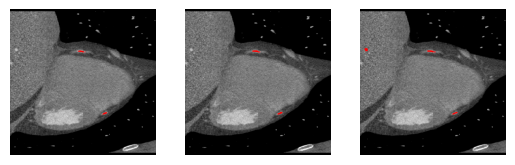

In [67]:
#plot
sls=":,190,:"
a=500
plt.figure()
plt.subplot(1,3,1)
plt.imshow(eval("vol_GT2["+sls+",:]"),extent=(0, a, 0, a))
plt.axis("off")
plt.subplot(1,3,2)
plt.imshow(eval("vol_FR2["+sls+",:]"), extent=(0, a, 0, a))
plt.axis("off")
plt.subplot(1,3,3)
plt.imshow(eval("vol_ClO["+sls+",:]"), extent=(0, a, 0, a))
plt.axis("off")


In [89]:
import torch
a = torch.tensor([1,-1])
b = torch.tensor([2,-2])
c = torch.tensor([3,-3])
v= [5,5,10]

z=[v_i*loss_i for v_i,loss_i in zip(v, [a,b,c])]

z2 = [torch.tensor(1), torch.tensor(2), torch.tensor(3)]
z

[tensor([ 5, -5]), tensor([ 10, -10]), tensor([ 30, -30])]

In [82]:
outputs = [{'loss':i.detach().numpy()} for i in  z]
outputs

[{'loss': array([ 5, -5])},
 {'loss': array([ 10, -10])},
 {'loss': array([ 30, -30])}]

In [83]:
collated={}
tmp = [o['loss'][None] for o in outputs]
collated['loss'] = np.vstack(tmp)

In [84]:
tmp

[array([[ 5, -5]]), array([[ 10, -10]]), array([[ 30, -30]])]

In [85]:
collated

{'loss': array([[  5,  -5],
        [ 10, -10],
        [ 30, -30]])}

In [91]:
outputs2 = [{'loss':i.detach().numpy()} for i in  z2]
print(outputs2)
collated2={}
tmp2 = [o['loss'][None] for o in outputs2]
collated2['loss'] = np.vstack(tmp2)
print(tmp2)
print(collated2)

[{'loss': array(1)}, {'loss': array(2)}, {'loss': array(3)}]
[array([1]), array([2]), array([3])]
{'loss': array([[1],
       [2],
       [3]])}


In [106]:
np.mean(collated['loss'],0)

array([ 15., -15.])

In [102]:
ddp = [collated['loss'], collated['loss'], collated['loss']]
print(ddp)
np.vstack(ddp).mean(0)

[array([[  5,  -5],
       [ 10, -10],
       [ 30, -30]]), array([[  5,  -5],
       [ 10, -10],
       [ 30, -30]]), array([[  5,  -5],
       [ 10, -10],
       [ 30, -30]])]


array([ 15., -15.])

In [ ]:
#TODO:
# -- check in 3D slicer how it looks in 3D aafter training with cl DSC and different weights... Perhaps it is now a single CC?
# Or is it completely off?
#
# -- implement trainers with other two losses that have code available
#
# -- start writing paper text; mentioning all methods available, särskilt TDA. And those you use. Also different methods on evaluation!
#
#

#ASAP write an eval code to check how good results actually seem to be (Dice unreliable). Plot also 
#differences between GT and segm, to see where largest deviations occur. Idea for eval code: how much 
#do deviations in volume actually affect the vessel crossesction? and the vessel length? IE stuff that's important from CFD perspective. 


In [ ]:
# Comment on cldsc: if deep supervision enabled on both cl and dsc losses, the GPU memory requirements nearly triple (17GB for a single run, while 6.8 GB for 
# low/fullres and stax over 7GB for cascade with using the normal nnUNet trainer). 
# How is it without deep supervision? Can same results be achieved with less memory?
#interestingly, per epoch time seems much lower. But then again - I was running three simultaneously when I ran original...

# Hm, 0.9+0.1 do 0.6+0.4 je DSC skor pri miru, doesnt budge; zgleda je premajhen contirbuiton? Ceprav je to ful cudno, ker dice loss 
# tut ostane dosti visje (in konstanten) kot pa CLdice, ki gre skor do nule...Sele pri 1+1 se lepo trenira tudi dice loss, in avg dsc 
# gre nad o.82. Mogoce to najboljse? Je pa opazit d je pri 0.9+0.1 cist raven, ko pa raste DSC contibution do  0.6+0.4 pa ze zacne mejcken
# fluktuirat, ceprav ne ful. JE pa res da 0.6+0.4 in 0.5+0.5 ni velke razlike; mogoce je stvar v premalem learning rate-u?
# mogoce je dice constanten ker napove povsod bckg? ALi pa povsod foreground?
# Potreben se visual check. 

In [38]:
imgname = "Normal_11.nrrd"

imgGT, headerIGT = nrrd.read(Path(gt_imgs, imgname[:-5]+'_0000.nrrd'))
imgGT[imgGT<-300]=-300
imgGT[imgGT>500] = 500
imgGT = (imgGT-imgGT.min())
imgGT = imgGT/imgGT.max() * 255
labGT, headerLGT = nrrd.read(Path(gt_label,imgname))
fantom = np.stack((imgGT, imgGT, imgGT), -1).astype(np.int32)

vol_GT = fantom.copy()
vol_GT[...,0][labGT>0] = 255
vol_GT[...,1][labGT>0] = 0
vol_GT[...,2][labGT>0] = 0



In [42]:
out, headerout = nrrd.read(Path('/home/maia-user/Desktop/nnUNet_results/Dataset666_ASOCA','nnUNetTrainer_300epochs__nnUNetPlans__3d_fullres' ,'fold_0','validation',imgname))
vol = fantom.copy()
vol[...,0][out>0] = 255
vol[...,1][out>0] = 0
vol[...,2][out>0] = 0

In [40]:
def get_volume(weights, imgname):
    mapa = 'nnUNetTrainerClDSC_'+weights+'__nnUNetPlans__3d_fullres'

    out, headerout = nrrd.read(Path('/home/maia-user/Desktop/nnUNet_results/Dataset666_ASOCA', mapa,'fold_6','validation',imgname))
    vol = fantom.copy()
    vol[...,0][out>0] = 255
    vol[...,1][out>0] = 0
    vol[...,2][out>0] = 0
    return vol

In [41]:
volumes = []
for w in ['9_1', '8_2', '7_3', '6_4', '1_1']:
    volumes.append(get_volume(w, imgname))


In [46]:
def ploti(sls):
    a=500
    plt.figure(figsize=(20,20))
    plt.subplot(3,3,1)
    plt.imshow(eval("vol_GT["+sls+",:]"),extent=(0, a, 0, a))
    plt.axis("off")
    plt.subplot(3,3,2)
    plt.imshow(eval("vol["+sls+",:]"), extent=(0,a,0,a)) #nnunet result
    plt.axis("off")
    for i in range(5):
        plt.subplot(3,3,4+i)
        plt.imshow(eval(f"volumes[{i}]["+sls+",:]"),extent=(0, a, 0, a))
        plt.axis("off")

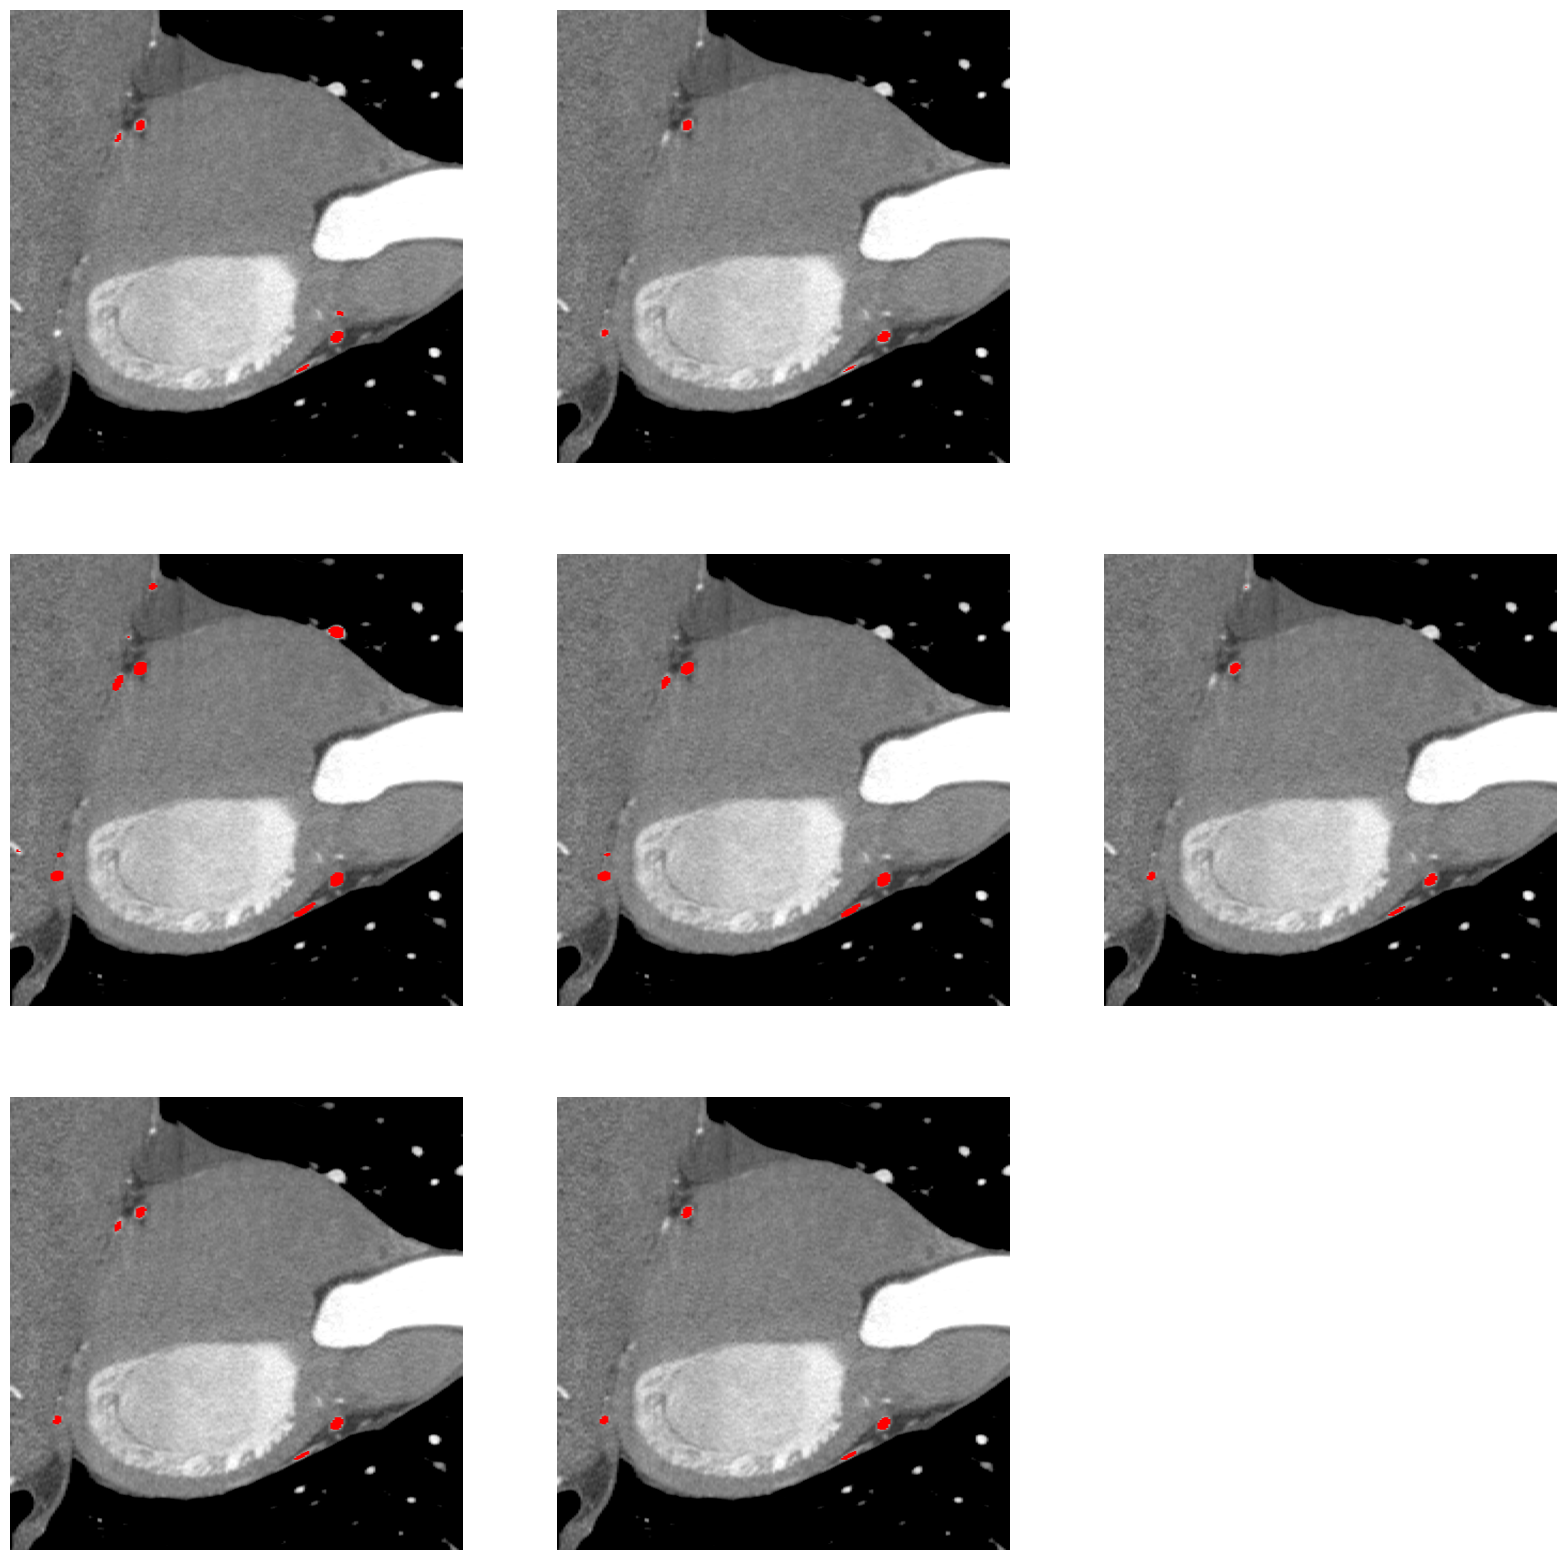

In [47]:
ploti(":,250,:")

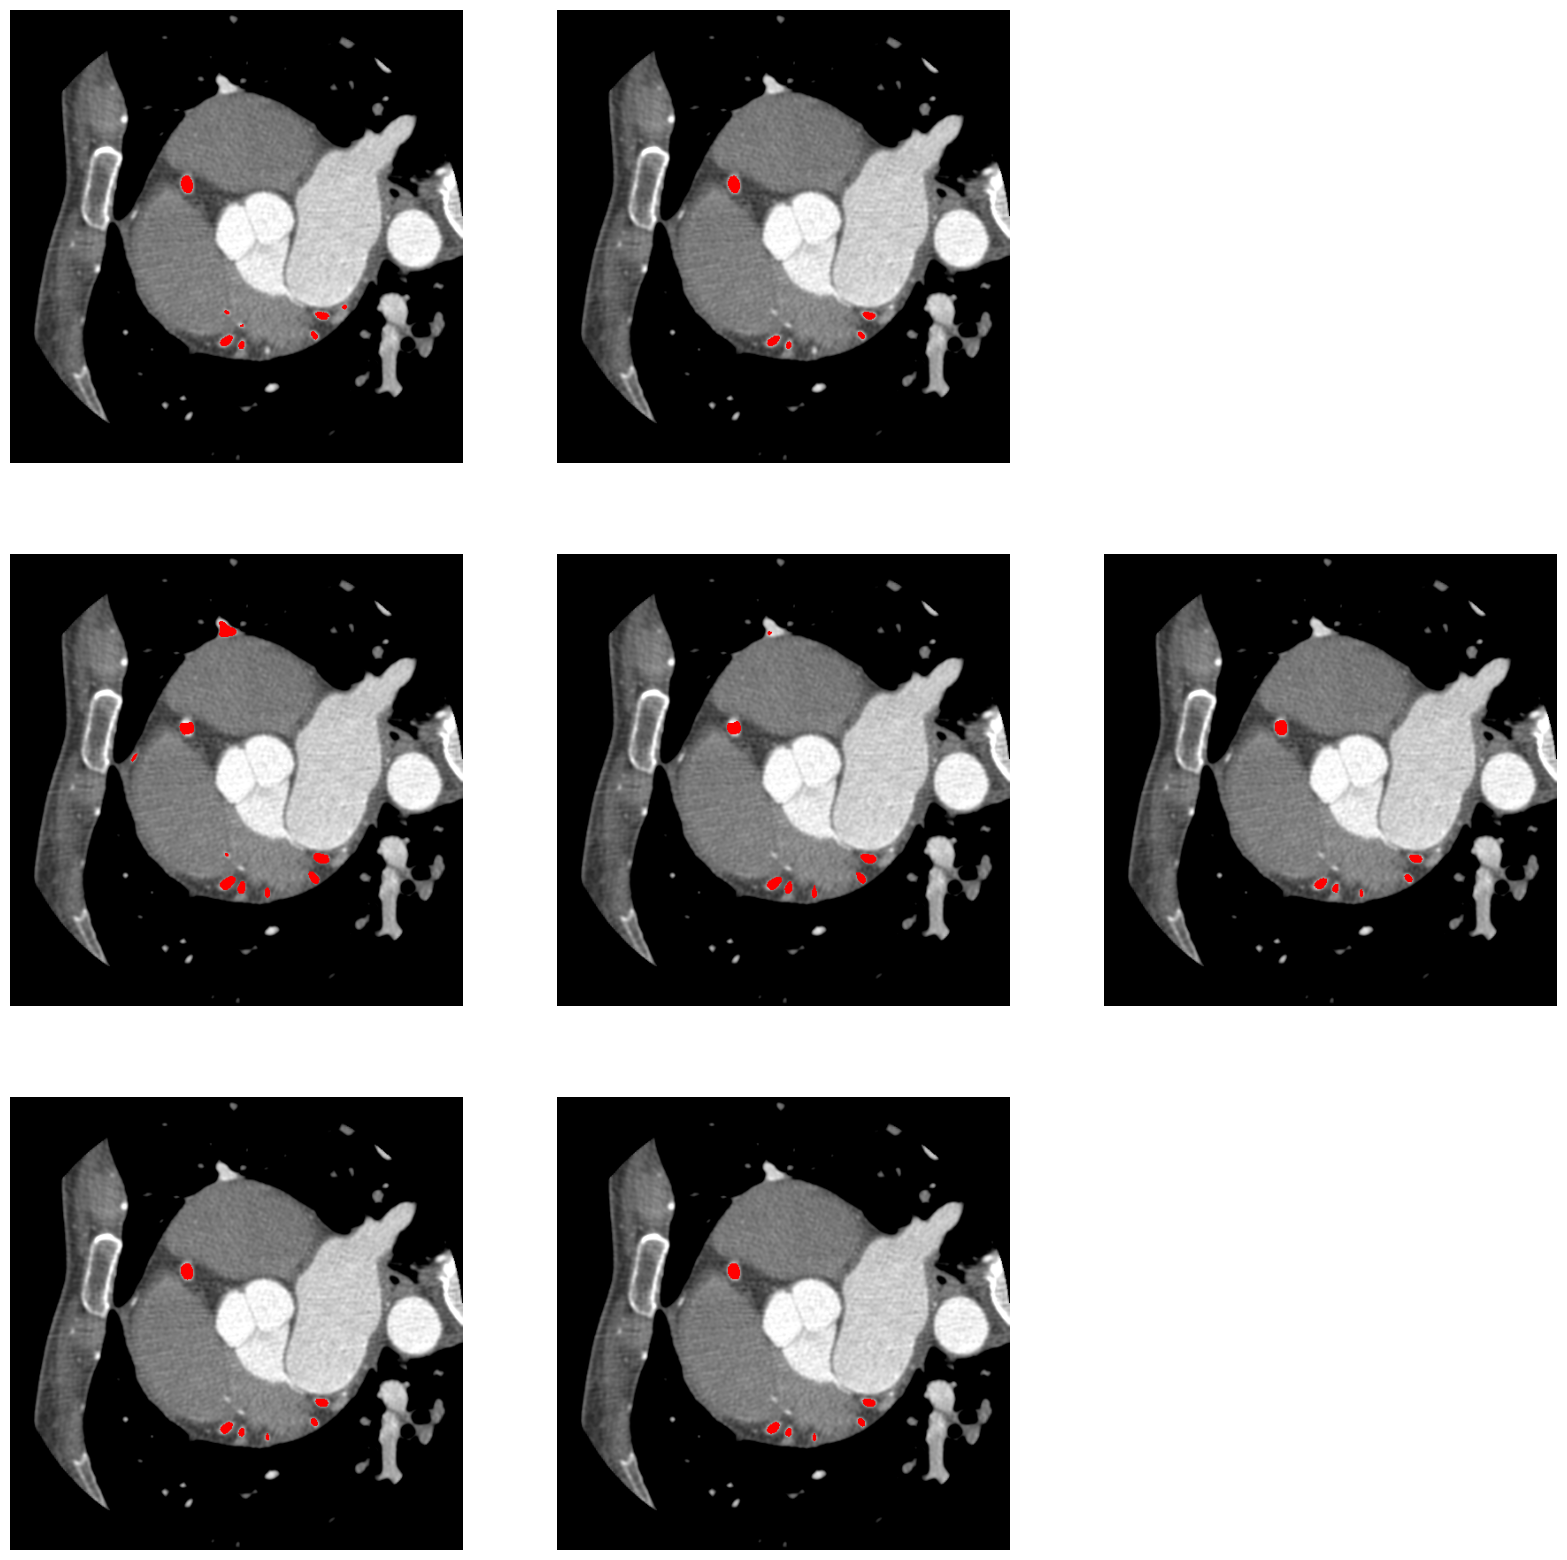

In [49]:
ploti(":,:,150")

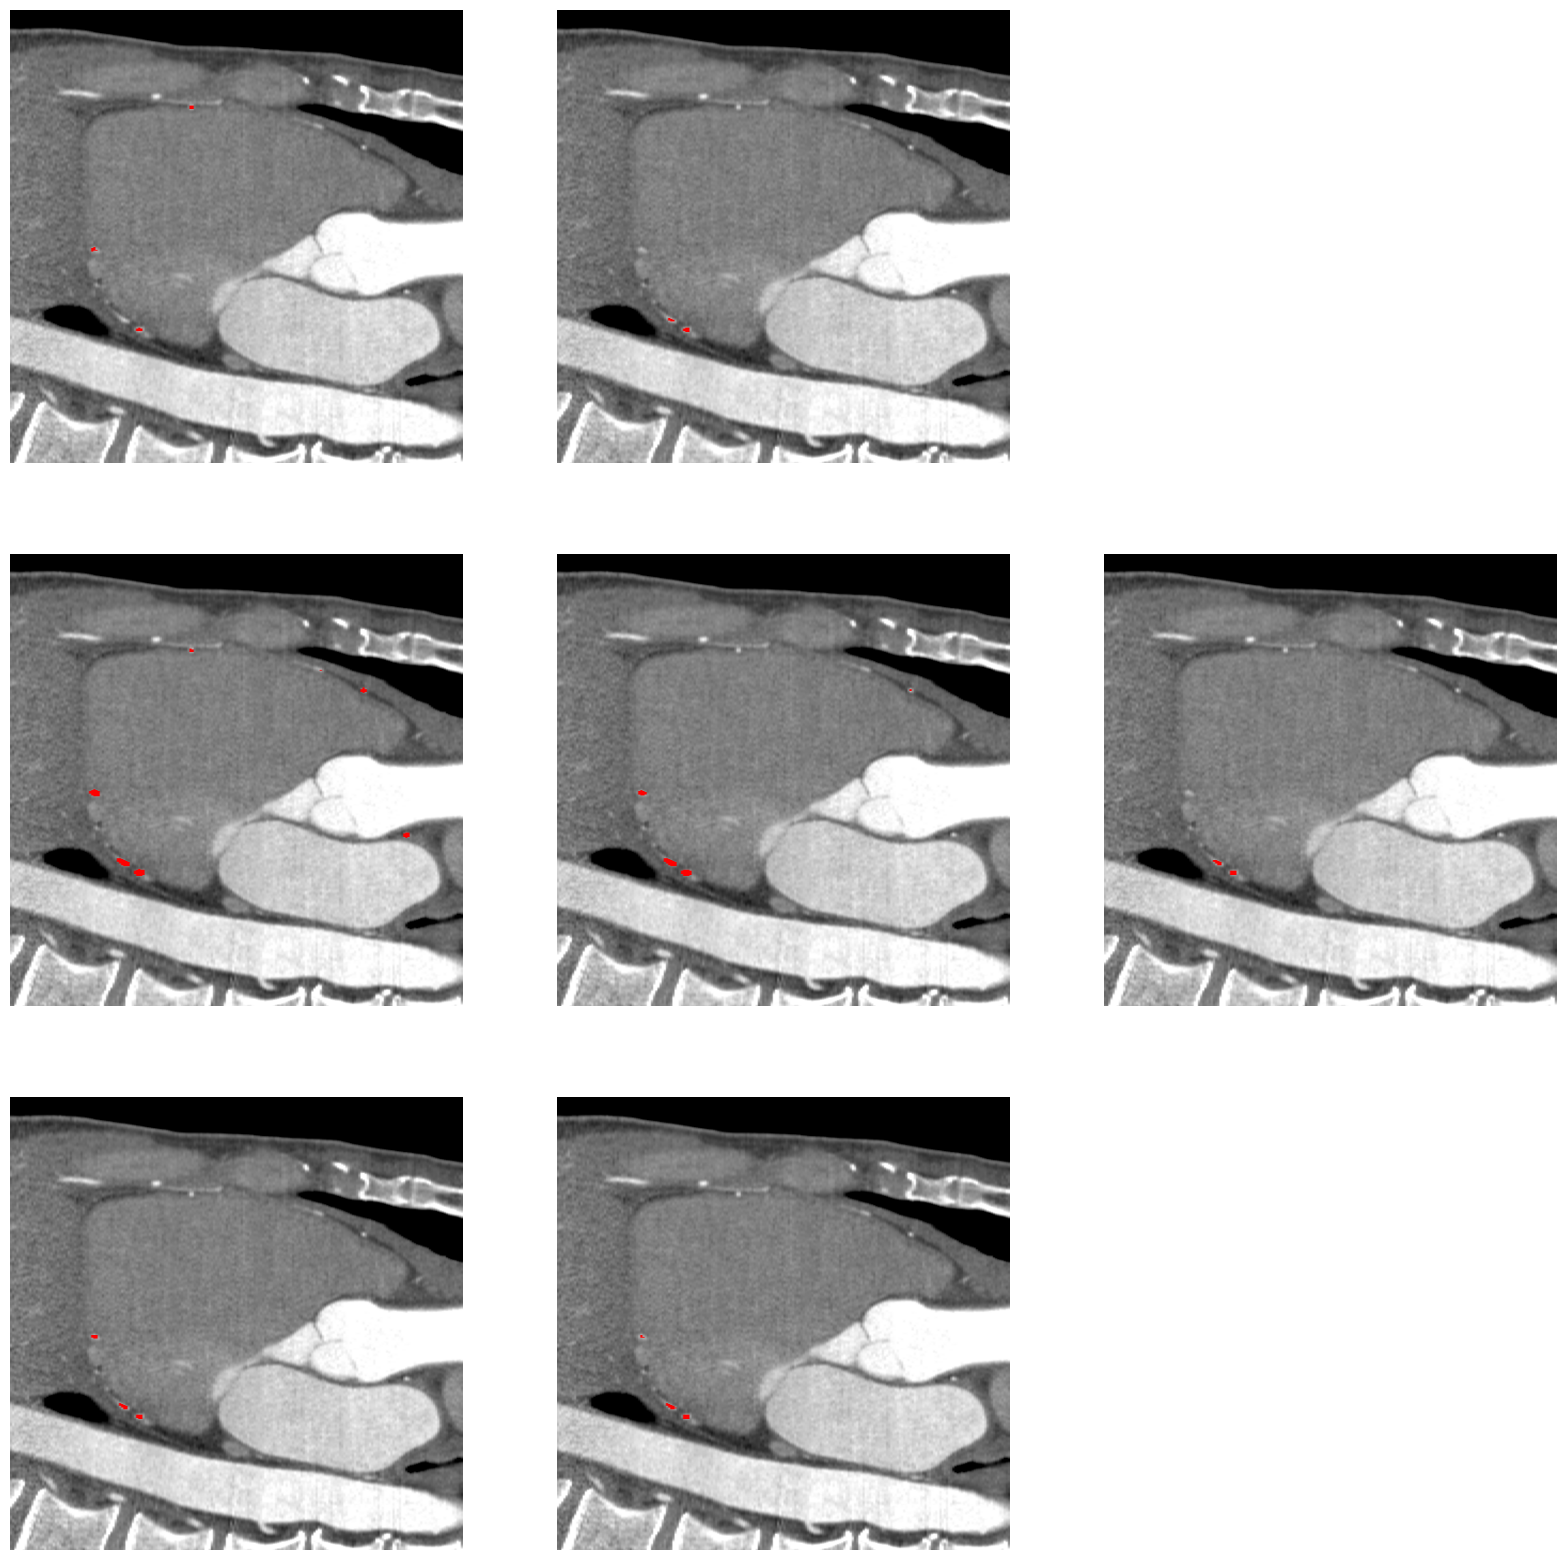

In [50]:
ploti("250,:,:")

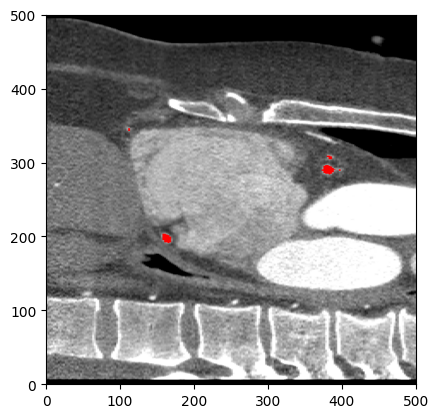

In [18]:
sls = "200,:,:"
a=500
plt.imshow(eval("vol_GT["+sls+",:]"), extent=(0, a, 0, a))

In [22]:
from scipy.ndimage import label, histogram
lab,n = label(labGT[200,:,:])

In [23]:
histogram(lab, 1, n, n)

array([ 4, 11, 65,  2, 51])

In [25]:
np.sqrt(65)*np.sqrt(2)

11.40175425099138

[ 11  12  13 107  50  71]
14.628738838327795


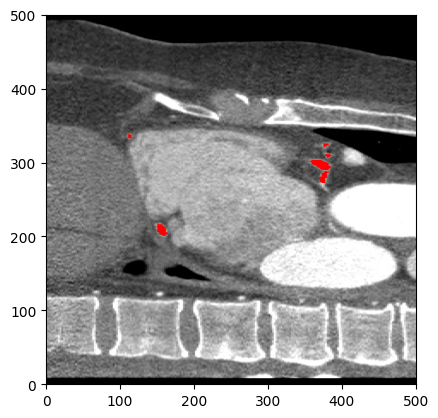

In [36]:
sls="190,:,:"

lab, n = label(eval("labGT["+sls+"]"))
hh=histogram(lab, 1, n, n)
print(hh)
print(np.sqrt(max(hh))*np.sqrt(2))

plt.imshow(eval("vol_GT["+sls+",:]"), extent=(0, a, 0, a))


In [2]:
lab_GT.shape

NameError: name 'lab_GT' is not defined

In [7]:
import numpy as np
h=np.random.randint(0,3,(5,5,5))

In [8]:
h

array([[[0, 0, 0, 1, 0],
        [2, 0, 1, 0, 1],
        [1, 0, 1, 2, 2],
        [0, 2, 0, 2, 0],
        [1, 0, 2, 0, 1]],

       [[2, 2, 1, 0, 1],
        [0, 2, 0, 2, 2],
        [2, 1, 2, 0, 0],
        [0, 0, 2, 2, 2],
        [1, 0, 0, 2, 0]],

       [[2, 1, 1, 1, 1],
        [1, 0, 1, 0, 2],
        [2, 2, 2, 0, 1],
        [0, 2, 2, 0, 2],
        [0, 1, 1, 1, 1]],

       [[0, 2, 2, 1, 0],
        [1, 2, 0, 1, 2],
        [2, 0, 1, 2, 1],
        [2, 0, 0, 2, 1],
        [2, 2, 1, 2, 2]],

       [[0, 2, 1, 0, 0],
        [0, 0, 2, 1, 1],
        [2, 2, 2, 2, 0],
        [0, 1, 0, 1, 0],
        [0, 1, 2, 2, 1]]])

In [12]:
h[:,0,:].any()

True

In [30]:
from pathlib import Path

srs = Path("HOEL/POEM-2D-GEO/train")
names = [iu.name for iu in Path(srs, "gt_npy").glob("*.npy")]
tomove = [iu for iu in Path(srs, "eucl_point_nnz").glob("*.npy") if iu.name not in names]
print(len(tomove))
print(len(names))


0
1066
4219


In [33]:
pp = list(Path("HOEL/POEM-2D-GEO/train/gt_npy").glob('*.npy'))
pp2 = list(Path("HOEL/POEM-2D-GEO/train/gt2_npy").glob('*.npy'))
pp.sort()
pp2.sort()
allbckg = open('allbckg.txt', 'w')
presentstats={1:0,2:0,3:0,4:0,5:0,6:0}
for el,el2 in zip(pp,pp2):
    print(el.name)
    assert el.name==el2.name, (el.name, el2.name)
    gt = np.argmax(np.load(el),axis=0)
    gt2 = np.argmax(np.load(el2),axis=0)
    assert gt.shape==(256,256), gt.shape
    present = np.unique(gt)
    for i in present[1:]:
        presentstats[i]+=1
    present2 = np.unique(gt2)
    print("    *",present, present2)
 #   print("    *",gt.shape, gt2.shape)
    if len(present)==1:
        allbckg.write(el.name+"\n")

allbckg.close()
    

subj500022_0_081.npy
    * [0 3] [0 3]
subj500022_0_082.npy
    * [0 3] [0 3]
subj500022_0_083.npy
    * [0 3] [0 3]
subj500022_0_084.npy
    * [0 3 5] [0 3 5]
subj500022_0_085.npy
    * [0 3 5] [0 3 5]
subj500022_0_086.npy
    * [0 3 5] [0 3 5]
subj500022_0_087.npy
    * [0 3 5] [0 3 5]
subj500022_0_088.npy
    * [0 3 5] [0 3 5]
subj500022_0_089.npy
    * [0 3 5] [0 3 5]
subj500022_0_090.npy
    * [0 3 5 6] [0 3 5 6]
subj500022_0_091.npy
    * [0 3 5 6] [0 3 5 6]
subj500022_0_092.npy
    * [0 3 5 6] [0 3 5 6]
subj500022_0_093.npy
    * [0 3 4 5 6] [0 3 4 5 6]
subj500022_0_094.npy
    * [0 3 4 5 6] [0 3 4 5 6]
subj500022_0_095.npy
    * [0 2 3 4 5 6] [0 2 3 4 5 6]
subj500022_0_096.npy
    * [0 2 3 4 5 6] [0 2 3 4 5 6]
subj500022_0_097.npy
    * [0 2 3 4 5 6] [0 2 3 4 5 6]
subj500022_0_098.npy
    * [0 2 3 4 5 6] [0 2 3 4 5 6]
subj500022_0_099.npy
    * [0 2 3 4 5 6] [0 2 3 4 5 6]
subj500022_0_100.npy
    * [0 2 3 6] [0 2 3 6]
subj500022_0_101.npy
    * [0 2 3 6] [0 2 3 6]
subj500022_0_

In [ ]:
allbckg = open('allbckg.txt', 'r')
for fajlname in allbckg.readlines():
    fajlname = fajlname.strip()
    print(fajlname)
    for i in ['gt','gt_npy','gt2_npy','img','img2_npy','random_npy']:
        Path("HOEL/POEM-2D-GEO/train/", i, fajlname).unlink()
        Path("HOEL/POEM-2D-GEO/train/", i, fajlname[-4:]+'.png').unlink()
allbckg.close()